# Seedtag codetest: NLP Researcher

## Part 1. Classification baseline model

This communication contains a classification baseline model.  However, according to our intelligence department:

- rebels have hacked some texts from one of the categories.

Thus, you should take care of noisy data when improving the baseline model.


In [7]:
pip install -r ../requirements.txt

  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 24.6 MB/s eta 0:00:00
Using cached click-8.1.7-py3-none-any.whl (97 kB)
Note: you may need to restart the kernel to use updated packages.


In [8]:
import os
import re
import itertools
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, plot_confusion_matrix
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk

import matplotlib.pyplot as plt


### 0. Auxiliary Functions

In [9]:
# Download NLTK stopwords
nltk.download('stopwords')

# Improved Data Cleaning
def clean_data(df):
    # Remove duplicates
    df = df.drop_duplicates()
    
    # Remove rows with null texts
    df = df.dropna(subset=['Text'])
    
    # Remove rows with very short texts (noise)
    df = df[df['Text'].str.len() > 10]
    
    return df

# Improved Feature Engineering
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    # Apply stemming
    stemmer = PorterStemmer()
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    
    return text



def create_df(path, tag):
    '''
    Creates a data frame for a given class
    --------------------------------------
    Input:
        path (str): path where all classes folders are stored.
        tag (str): name of the folder containing class "tag".
    Output:
        df (pd.DataFrame): dataframe with file as index and columns=[text, tag]
    '''
    list_of_text = []
    tag_dir = os.path.join(path, tag)
    for file in os.listdir(tag_dir):
        with open(os.path.join(tag_dir, file), encoding="utf-8", errors="ignore") as f:
            text = f.read()
            list_of_text.append((text, file))
    df = pd.DataFrame(list_of_text, columns=['Text', 'file'])
    df = df.set_index('file')
    df['tag'] = tag
    return df

def get_all_dfs(path, tags):
    '''
    Loops over all classes in path, each in the corresponding folder
    --------------------------------
    Input:
        path (str): path where all classes folders are stored.
        tags (list): list of classes names.
    Output:
        df (pd.DataFrame): pandas dataframe with the dataframes corresponding to all classes concatenated.
    '''
    list_of_dfs = []
    for tag in tags:
        df = create_df(path, tag)
        list_of_dfs.append(df)
    data = pd.concat(list_of_dfs)
    return data
    


def tfidf_features(X_train, X_val, X_test, max_features=None):
    """
        X_train, X_val, X_test — samples
        return TF-IDF vectorized representation of each sample and vocabulary
    """
    tfidf_vectorizer = TfidfVectorizer(
        max_features=max_features,
        min_df=10,
        max_df=0.1,
        ngram_range=(1,1),
        stop_words='english',
        token_pattern=r'([a-zA-Z0-9-/]{2,})')
    X_train = tfidf_vectorizer.fit_transform(X_train)
    X_val = tfidf_vectorizer.transform(X_val)
    X_test = tfidf_vectorizer.transform(X_test)

    return X_train, X_val, X_test, tfidf_vectorizer.vocabulary_


def _score(y_true, y_pred):
    diff = (y_true - y_pred)
    return np.log1p(diff)


def train_clf(X_train, y_train, sol, c, pen):
    """
    X_train, y_train: training data
    c: regularization parameter for LogisticRegression
    pen: penalty for LogisticRegression

    return: trained classifier
    """
    clf = OneVsRestClassifier(
        LogisticRegression(solver=sol, C=c, penalty=pen, class_weight='balanced'),
        n_jobs=-1)
    clf.fit(X_train, y_train)
    return clf
    

def parameter_search(model, X_train, y_train, X_val, y_val, solver_grid, c_grid, pen_grid, verbose=False):
    '''
    model: pretrained model
    X_train, y_train: training data
    X_val, y_val: validation data
    c_grid: values for regularization c parameter
    pen_grid: values for penalty parameter
    verbose (bool): whether the score values during hyperparameter tunning are displayed.

    return: best parameters, best classifier
    '''
    ac_scores = []
    scores = []
    grid = [(sol, c, pen) for sol in solver_grid for c in c_grid for pen in pen_grid]
    for sol, c, pen in tqdm(grid):

        gen_classifier = model(X_train, y_train, sol, c, pen)
        y_pred = gen_classifier.predict(X_val)
        ac_score, score = accuracy_score(y_val, y_pred), f1_score(y_val, y_pred, average='weighted')
        if verbose:
            print('For parameters ({}, {:3.2f}, {}), (accuracy, f1_score) are: ({:.6f}, {:.6f})'.format(
                sol, c, pen, ac_score, score))
        ac_scores.append(ac_score)
        scores.append(score)
    best_ind = np.argmax(np.array(scores))
    best_parms = grid[best_ind]
    best_clf = train_clf(X_train, y_train, best_parms[0], best_parms[1], best_parms[2])
    print('Model generated: the best values for the parameters are {}'.format(best_parms))
    return best_clf
    

def train(dir_name):
    """
    Wrap up function that trains a classification model.
    --------------------------------------------------
    Input:
        dir_name (str): name if the folder containing one subfolder for each class.
    Output:
        model (estimator): LogisticRegression classification model based on OneVsRest approach,
        with a tfidf vector representation for the features.
    """

    tags = os.listdir(path)

    ## data cleaning
    data_full = get_all_dfs(dir_name, tags)
    data_dedup = data_full.drop_duplicates()
    null_texts = data_dedup[data_dedup.Text.duplicated(keep=False)].index
    data = data_dedup.drop(index=null_texts)

    ## text preprocessing
    data_prep = data.copy()

    ## spliting data
    X, X_test, y, y_test = train_test_split(data_prep['Text'], data_prep['tag'], test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    ## tfidf_vector representation
    ## features
    X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(
        X_train, X_val, X_test)
    ## labels
    lb = LabelBinarizer()
    y_train_enc = lb.fit_transform(np.transpose([y_train]))
    y_val_enc = lb.transform(y_val)

    ## model training
    SOLVER_GRID = ['liblinear', 'saga']
    C_GRID = [0.01, 0.1, 1, 10, 100, 1000]
    PEN_GRID = ['l1', 'l2']
    print('Training model...')
    model = parameter_search(train_clf, X_train_tfidf, y_train_enc, X_val_tfidf, y_val_enc, SOLVER_GRID, C_GRID, PEN_GRID)
    return model


## Evaluation

def plot_learning_curve(estimator, title, X, y):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features).

    y : array-like, shape (n_samples) or (n_samples, n_features).

    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].set_title(title)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator, X, y, cv=5, n_jobs=4, train_sizes=np.linspace(0.1, 1, 6), return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1)
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1)
    axes[0].plot(train_sizes, train_scores_mean, 'o-', label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

def plot_confusion_matrix(
    cm, classes,
    title='Confusion matrix',
    cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=15)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    

def evaluate_model(model):
    """
    Generates a set of evaluation tools for the model
    Input:
        model (estimator)
    Output:
        None, prints the score for the test set using accuracy and f1_weighted, it also plots the learning
        curve and the confusion matrix.
    """

    lb = LabelBinarizer()
    y_train_enc = lb.fit_transform(np.transpose([y_train]))
    y_test_enc = lb.transform(y_test)

    y_test_predictions = model.predict(X_test_tfidf)
    y_test_pred = lb.inverse_transform(y_test_predictions)
    ac_score, score = accuracy_score(y_test, y_test_pred), f1_score(y_test, y_test_pred, average='weighted')
    print('(accuracy, f1) are: ({:.6f}, {:.6f})'.format(ac_score, score))

    # learning curve
    plot_learning_curve(model, "Learning Curves (LogReg)", X_train_tfidf, y_train_enc)
    plt.show()

    # testing
    print(classification_report(y_test, y_test_pred))
    # Plot non-normalized confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(12,10))
    plot_confusion_matrix(cnf_matrix, classes=lb.classes_, title="Confusion matrix")
    plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/carlosrosado/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 1. Loading data

In [10]:
# Load and clean data
path = '../part1/dataset'
tags = os.listdir(path)
tags

['transportation',
 'intelligence',
 'weapons',
 'exploration',
 'politics',
 'headhunters',
 'logistics']

In [11]:
data_full = get_all_dfs(path, tags)
print(data_full.shape)
data_full.tail()

(3853, 2)


,Text,tag
file,,
51278,\nIn <1993Apr4.093904.20517@proxima.alt.za> lu...,logistics
53180,\nAndrew Newell <TAN102@psuvm.psu.edu> writes:...,logistics
53510,\nIn article <C5L1Fv.H9r@ra.nrl.navy.mil> khan...,logistics
51247,\nTony Lezard <tony@mantis.co.uk> writes:\n\n>...,logistics
53174,\nlivesey@solntze.wpd.sgi.com (Jon Livesey) wr...,logistics


In [12]:
# Apply the improvements
data_cleaned = clean_data(data_full)

data_cleaned['Text'] = data_cleaned['Text'].apply(preprocess_text)


data = data_cleaned.copy()

In [13]:
data

,Text,tag
file,,
103084,anoth user recent request info shadowsund car ...,transportation
103242,aprcoloradoedu drewkinglearcscoloradoedu drew ...,transportation
102955,articl aprnewsengconvexcom dodsonconvexcom dav...,transportation
102999,gday peopl mr owner motorhead guru know mr eng...,transportation
103413,buick skylark k bought california itll let id ...,transportation
...,...,...
51278,aprproximaaltza lucioproximaaltza lucio de wri...,logistics
53180,andrew newel tanpsuvmpsuedu write think suppor...,logistics
53510,articl clfvhrranrlnavymil khanitditdnrlnavymil...,logistics


politics          604
transportation    593
exploration       586
headhunters       581
weapons           546
logistics         469
intelligence      453
Name: tag, dtype: int64


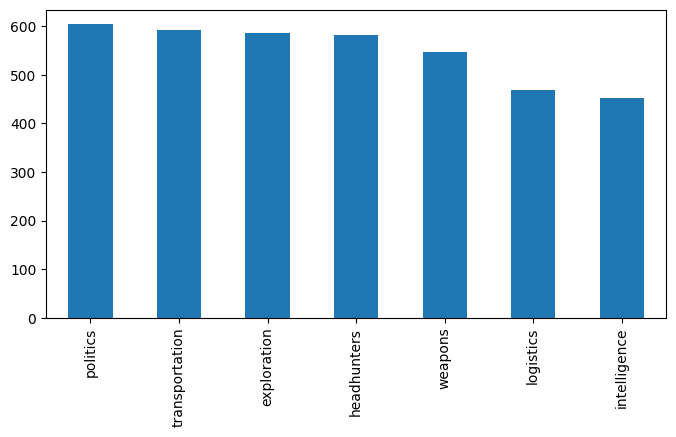

In [14]:
print(data['tag'].value_counts())
plt.figure(figsize=(8,4))
data['tag'].value_counts().plot(kind='bar');

In [15]:
data_prep = data.copy()

### 2. Features representation

In [16]:
X, X_test, y, y_test = train_test_split(data_prep['Text'], data_prep['tag'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:

X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_val, X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

### 3. Training

In [18]:
# Hyperparameter Tuning
SOLVER_GRID = ['liblinear', 'saga']
C_GRID = [0.01, 0.1, 1, 10, 100, 1000]
PEN_GRID = ['l1', 'l2']

lb = LabelBinarizer()
y_train_enc = lb.fit_transform(np.transpose([y_train]))
y_val_enc = lb.transform(y_val)

# Train the model with improved data and hyperparameters
classifier_tfidf = parameter_search(train_clf, X_train_tfidf, y_train_enc, X_val_tfidf, y_val_enc, SOLVER_GRID, C_GRID, PEN_GRID)



 67%|██████▋   | 16/24 [00:04<00:01,  6.07it/s]/Users/carlosrosado/Desktop/Inter/NLP-CODETEST/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/carlosrosado/Desktop/Inter/NLP-CODETEST/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/carlosrosado/Desktop/Inter/NLP-CODETEST/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/carlosrosado/Desktop/Inter/NLP-CODETEST/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/carlosrosado/Desktop/Inter/NLP-CODETEST/.venv/lib/python3.10/site-packages/skl

Model generated: the best values for the parameters are ('saga', 100, 'l2')


### 4. Evaluation

(accuracy, f1) are: (0.906128, 0.908857)


/Users/carlosrosado/Desktop/Inter/NLP-CODETEST/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/carlosrosado/Desktop/Inter/NLP-CODETEST/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/carlosrosado/Desktop/Inter/NLP-CODETEST/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/carlosrosado/Desktop/Inter/NLP-CODETEST/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/carlosrosado/Desktop/Inter/NLP-CODETEST/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarni

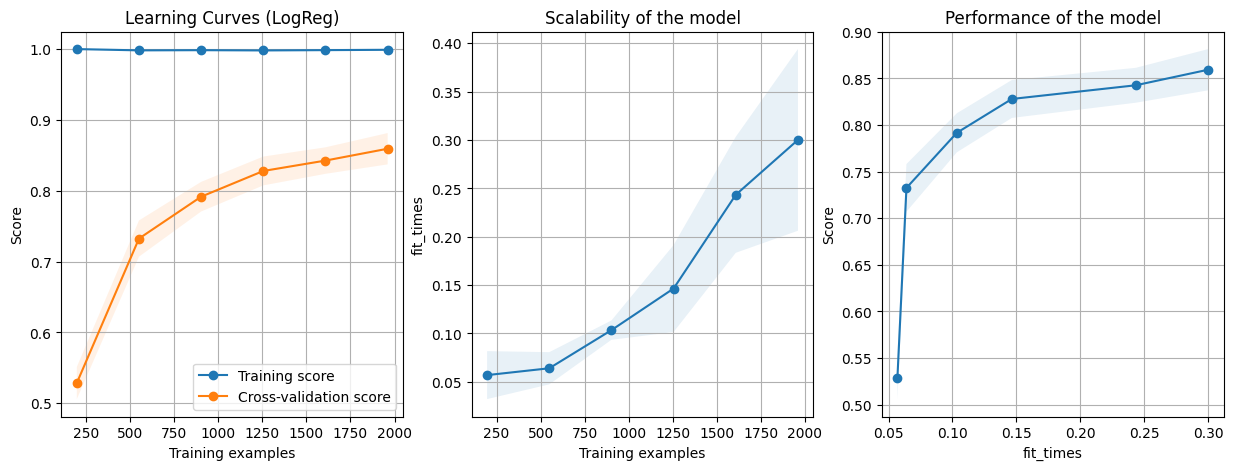

                precision    recall  f1-score   support

   exploration       0.70      0.96      0.81       101
   headhunters       0.93      0.92      0.93       108
  intelligence       0.96      0.84      0.89        80
     logistics       0.96      0.90      0.93       104
      politics       0.94      0.92      0.93       129
transportation       0.96      0.90      0.93       142
       weapons       0.97      0.88      0.92       103

      accuracy                           0.91       767
     macro avg       0.92      0.90      0.91       767
  weighted avg       0.92      0.91      0.91       767



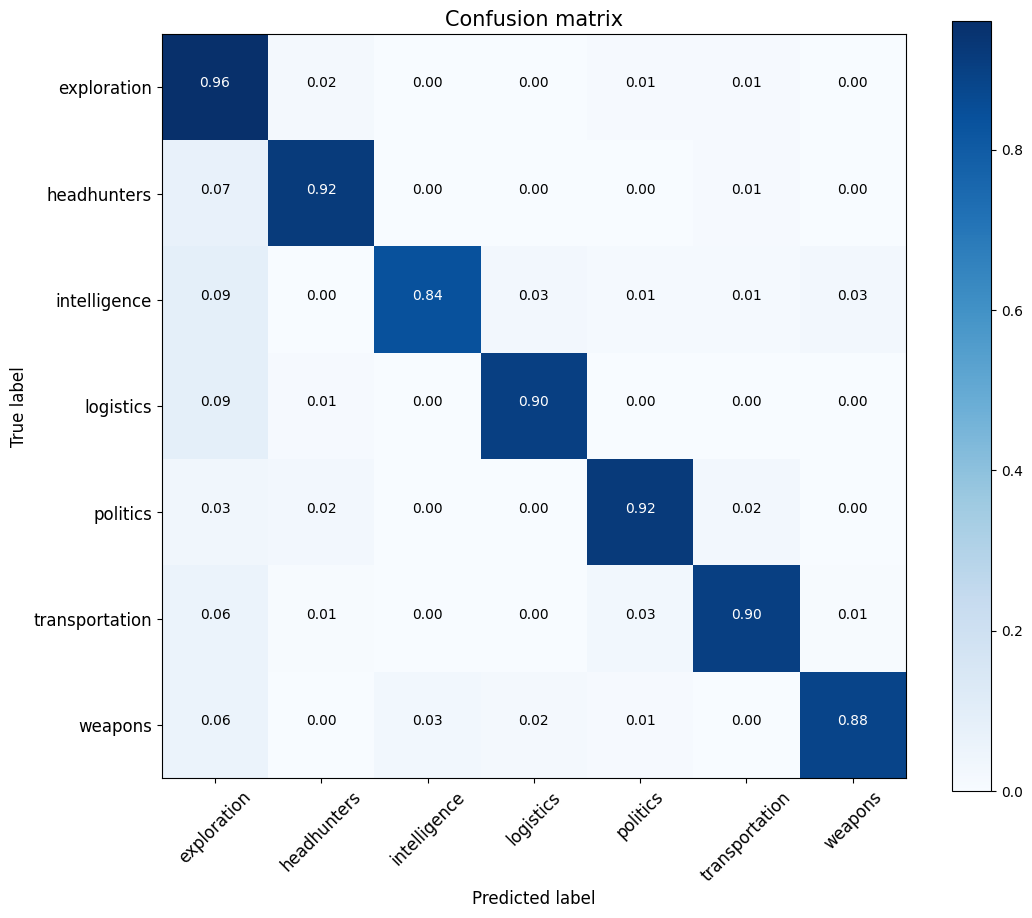

In [19]:
evaluate_model(classifier_tfidf)